In [175]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import sklearn
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score,make_scorer
from ConstructDatatset import *
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from TotalCalculation import *
from preprocessing import *
from ClassPrediction import *

In [176]:
df1 = Builddataset().concateDataset(folder_name = r'C:\Users\ASUS\Documents\NARIT_internship_data\CSV_dataset_4\Dataset_06_2024')
df2 = Builddataset().concateDataset(folder_name = r'C:\Users\ASUS\Documents\NARIT_internship_data\CSV_dataset_4\Dataset_12_2023')
df3 = Builddataset().concateDataset(folder_name = r'C:\Users\ASUS\Documents\NARIT_internship_data\CSV_dataset_old\Dataset_06_2024')
df4 = Builddataset().concateDataset(folder_name = r'C:\Users\ASUS\Documents\NARIT_internship_data\CSV_dataset_old\Dataset_12_2023')
df5 = Builddataset().concateDataset(folder_name = r'C:\Users\ASUS\Documents\NARIT_internship_data\CSV_dataset_3\Dataset_06_2024')
df6 = Builddataset().concateDataset(folder_name = r'C:\Users\ASUS\Documents\NARIT_internship_data\CSV_dataset\Dataset_12_2023')

In [177]:
date1 = []
for i in df1.index.tolist():
    date1.append(timeConvertion().ticks_to_datetime(i,time_zone=7))
df1['Time'] = date1
date2 = []
for i in df2.index.tolist():
    date2.append(timeConvertion().ticks_to_datetime(i,time_zone=7))
df2['Time'] = date2
date3 = []
for i in df3.index.tolist():
    date3.append(timeConvertion().ticks_to_datetime(i,time_zone=7))
df3['Time'] = date3
date4 = []
for i in df4.index.tolist():
    date4.append(timeConvertion().ticks_to_datetime(i,time_zone=7))
df4['Time'] = date4
date5 = []
for i in df5.index.tolist():
    date5.append(timeConvertion().ticks_to_datetime(i,time_zone=7))
df5['Time'] = date5
date6 = []
for i in df6.index.tolist():
    date6.append(timeConvertion().ticks_to_datetime(i,time_zone=7))
df6['Time'] = date6

In [178]:
df1['Time (decimal)'] = df1['Time'].dt.hour+df1['Time'].dt.minute/60
df2['Time (decimal)'] = df2['Time'].dt.hour+df2['Time'].dt.minute/60
df3['Time (decimal)'] = df3['Time'].dt.hour+df3['Time'].dt.minute/60
df4['Time (decimal)'] = df4['Time'].dt.hour+df4['Time'].dt.minute/60
df5['Time (decimal)'] = df5['Time'].dt.hour+df5['Time'].dt.minute/60
df6['Time (decimal)'] = df6['Time'].dt.hour+df6['Time'].dt.minute/60

name_y = str('Blue channel')
name_x = np.arange(len(df))
dintr = np.gradient(df['Blue channel'])
dintb = np.gradient(df['Red channel'])

plt.figure(figsize=(30,20))
sns.lineplot(data=df,x=name_x,y=df[name_y],c='blue')
sns.lineplot(data=df,x=name_x,y=df['Red channel'],c='green')
sns.lineplot(data=df,x=name_x,y=df['intensity'])
plt.plot(dintr)
plt.plot(dintb,c='r')

df

In [179]:
start_date = '2024-01-01'
end_date = str(df1['Time'].tolist()[1])
location = [18.849417,98.9538]
days = timeConvertion().time_duration(start_date,end_date,include_end_date=True).days

LSTM = SunPosition.LSTM(time_zone_offset=7)
EoT = SunPosition.calculate_EoT(day=days)
TC = SunPosition.TimeCorrectionFactor(Longitude=location[1],LSTM=LSTM,EoT=EoT)
dec = SunPosition.declination(day=days)
suntime = SunPosition.DaytimeInfo(latitude=location[0],declination=dec,TC=TC)
sunrise1,sunset1 = SunPosition.DaytimeInfo(latitude=location[0],declination=dec,TC=TC)

start_date = '2023-01-01'
end_date = str(df2['Time'].tolist()[1])
location = [18.849417,98.9538]
days = timeConvertion().time_duration(start_date,end_date,include_end_date=True).days

LSTM = SunPosition.LSTM(time_zone_offset=7)
EoT = SunPosition.calculate_EoT(day=days)
TC = SunPosition.TimeCorrectionFactor(Longitude=location[1],LSTM=LSTM,EoT=EoT)
dec = SunPosition.declination(day=days)
suntime = SunPosition.DaytimeInfo(latitude=location[0],declination=dec,TC=TC)
sunrise2,sunset2 = SunPosition.DaytimeInfo(latitude=location[0],declination=dec,TC=TC)

In [180]:
print(sunrise1,sunset1)

5.835056425850403 18.95067921821431


In [181]:

df1 = Builddataset().DayNightSplit(suntime=[sunrise1,sunset1],Mode='day',dataframe=df1)
df2 = Builddataset().DayNightSplit(suntime=[sunrise2,sunset2],Mode='day',dataframe=df2)
df3 = Builddataset().DayNightSplit(suntime=[sunrise1,sunset1],Mode='day',dataframe=df3)
df4 = Builddataset().DayNightSplit(suntime=[sunrise2,sunset2],Mode='day',dataframe=df4)
df5 = Builddataset().DayNightSplit(suntime=[sunrise1,sunset1],Mode='day',dataframe=df5)
df6 = Builddataset().DayNightSplit(suntime=[sunrise2,sunset2],Mode='day',dataframe=df6)
df = pd.concat([df1,df2,df3,df4,df5,df6])

In [182]:
df

,contrast,dissimilarity,homogeneity,energy,correlation,ASM,intensity,Red channel,Blue channel,skewness,std,different(R-B),Time,Time (decimal)
638535703952838218,258.895661,3.522271,0.512228,0.243385,0.974308,0.059236,119.004454,107.986319,119.004454,-40.115536,83.646566,-11.018135,2024-06-10 05:53:15.283824,5.883333
638535705153481533,261.483226,3.649977,0.497423,0.240407,0.975313,0.057796,120.801683,107.371875,120.801683,-97.934114,82.669298,-13.429808,2024-06-10 05:55:15.348152,5.916667
638535706354006269,314.319757,4.007068,0.491213,0.250102,0.971175,0.062551,118.750708,104.932485,118.750708,-81.756958,81.255461,-13.818223,2024-06-10 05:57:15.400624,5.950000
638535707554290911,322.032101,4.178299,0.488095,0.244494,0.971113,0.059777,112.466319,99.472505,112.466319,-16.838659,79.575196,-12.993814,2024-06-10 05:59:15.429088,5.983333
638535708755301005,307.787177,4.279353,0.483526,0.241418,0.973548,0.058283,111.694318,99.838447,111.694318,-33.953255,78.685882,-11.855871,2024-06-10 06:01:15.530104,6.016667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638377149746702169,195.828461,2.769176,0.673308,0.364216,0.970288,0.132653,93.704870,58.920669,93.704870,-79.559154,68.204806,-34.784201,2023-12-09 17:36:14.670216,17.600000
638377150947862280,200.003600,2.770689,0.639779,0.302371,0.971447,0.091428,97.779016,65.007739,97.779016,-101.343731,70.672799,-32.771277,2023-12-09 17:38:14.786224,17.633333
638377152148988685,224.482432,2.637720,0.674527,0.305784,0.969698,0.093504,97.002625,65.265344,97.002625,-47.510806,72.125326,-31.737281,2023-12-09 17:40:14.898872,17.666667
638377153350194187,223.712065,2.664867,0.716201,0.407952,0.973122,0.166425,97.362713,61.965153,97.362713,-26.399902,72.859932,-35.397560,2023-12-09 17:42:15.019416,17.700000


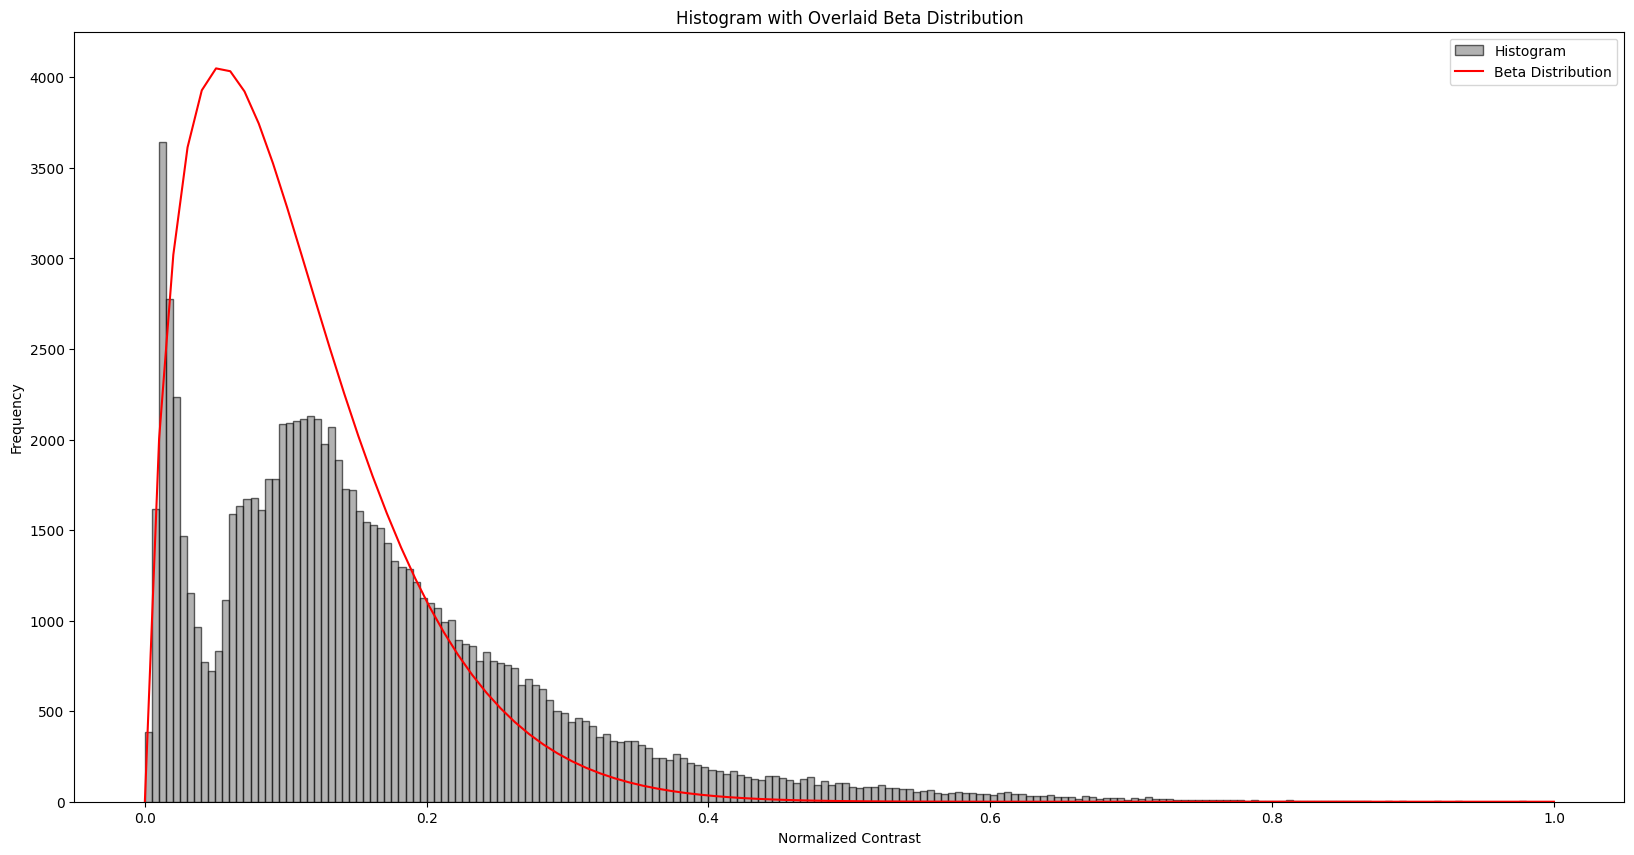

In [183]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Assuming df['contrast'] is your data, normalize it to [0, 1]
contrast_min = df['contrast'].min()
contrast_max = df['contrast'].max()
normalized_contrast = (df['contrast'] - contrast_min) / (contrast_max - contrast_min)

# Plot the histogram of the normalized contrast
plt.figure(figsize=(20, 10))
plt.hist(normalized_contrast, bins=200, alpha=0.6, color='gray', edgecolor='black', label='Histogram')

# Parameters for the Beta distribution
alpha_param = 1.8
beta_param = 15

# Generate x values for the Beta distribution
x = np.linspace(0, 1, 100)

# Beta distribution PDF
y = beta.pdf(x, alpha_param, beta_param)

# Scale y to match the histogram's scale
y = y * len(normalized_contrast)/1.5 * (x[1] - x[0])

# Overlay the Beta distribution line plot
plt.plot(x, y, color='red', label='Beta Distribution')

# Add labels and title
plt.xlabel('Normalized Contrast')
plt.ylabel('Frequency')
plt.title('Histogram with Overlaid Beta Distribution')

# Show legend
plt.legend()

# Show the plot
plt.show()



In [199]:
plt.figure(figsize=(12,10))
sns.heatmap(data=np.std(df.drop(columns=['Time'])),annot=True,cmap='jet')

In [185]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, QuantileTransformer, RobustScaler, StandardScaler
X = df.drop(columns=['Time','Time (decimal)','correlation'])
#iso = IsolationForest(contamination=0.21,max_samples=0.1,n_estimators=204)  # Adjust contamination level
scaler = RobustScaler()
scaler.fit(X)
scaled = scaler.transform(X)
#iso.fit(scaled)
#outliers = iso.predict(scaled)
#cleaned_data = scaled[outliers == 1] 
pca = PCA(n_components=2,svd_solver='full')
pca.fit(scaled)
principal = pca.transform(scaled)
dataset = principal

with open('PCA_slide_3.pkl', 'wb') as f:
    pickle.dump(pca, f)
with open('Scaler_slide_3.pkl', 'wb') as f:
    pickle.dump(scaler, f)

3643.0
0.8867072190691414
-0.8825677889765362
Mean :  0.19126163747265734
Median :  0.0


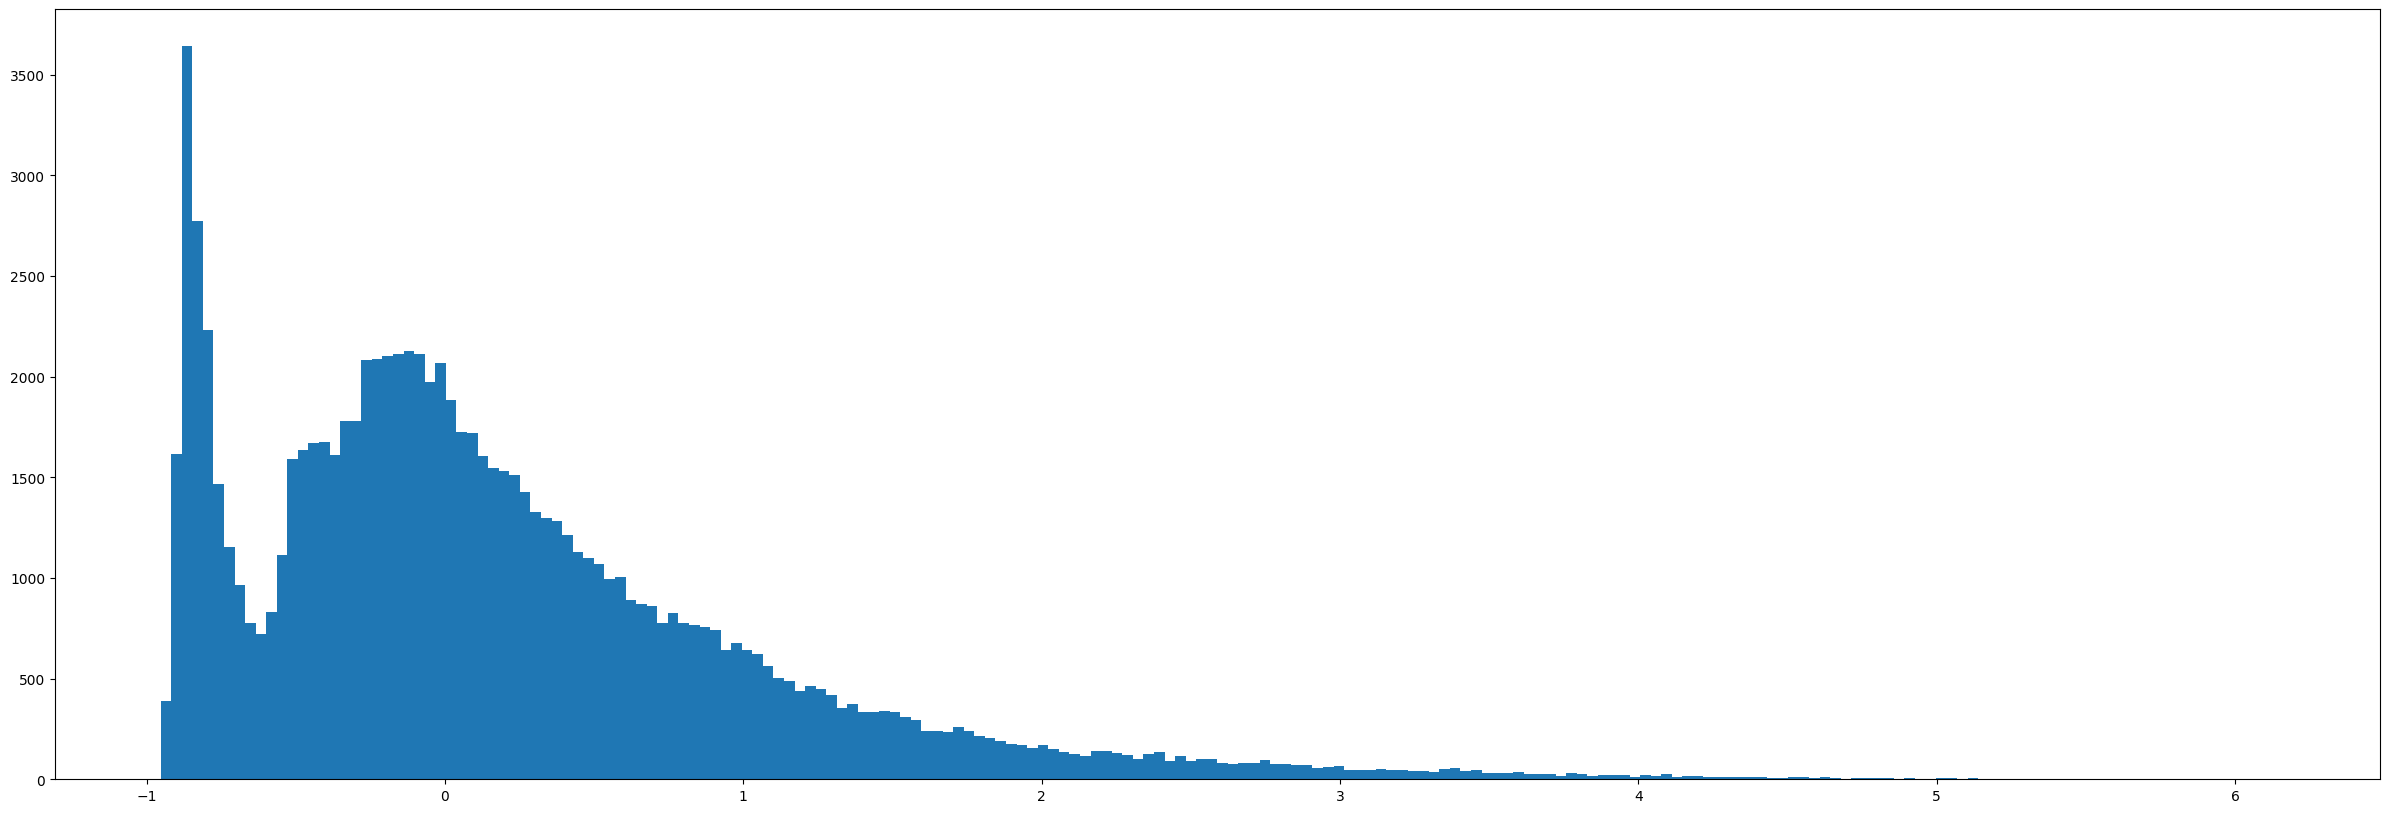

In [186]:
num = 0
plt.figure(figsize=(30,10))
arr1 = plt.hist(scaled[:,num],bins=200,log=False)
print(max(arr1[0]))
print(np.std(scaled[:,num]))
print(arr1[1][np.argmax((arr1[0]))])
print("Mean : ",np.mean(scaled[:,num]))
print("Median : ",np.median(scaled[:,num]))
#plt.axvline(np.mean(df[feature]),c='r')
#plt.axvline(np.median(df[feature]),c='y')

import pickle
with open('PCA_2.pkl', 'wb') as f:
    pickle.dump(pca, f)
with open('MinMaxscaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

[0.47523208 0.28637964]


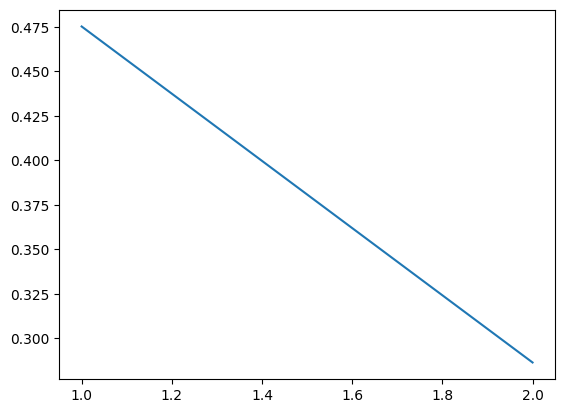

In [187]:
plt.plot(np.arange(pca.n_components_)+1,pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_)

<Axes: >

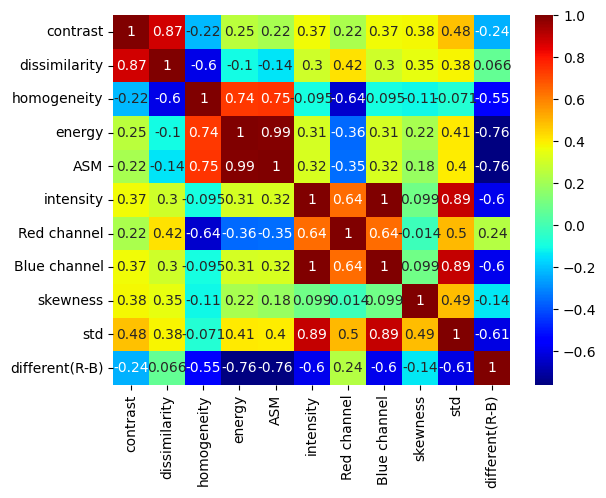

In [188]:
sns.heatmap(data=X.corr(),cmap='jet',annot=True)

In [189]:
from sklearn.metrics.pairwise import euclidean_distances
np.random.seed(42)
kmeans = KMeans(init='k-means++', n_clusters=5, n_init=20,
                random_state=42,tol=1e-4,max_iter=300,algorithm='lloyd')
GMM = GaussianMixture(n_components=5, tol=1e-4, init_params='k-means++',
                      covariance_type='full', max_iter=300, random_state=42, n_init=20)
#minik = MiniBatchKMeans(n_clusters=5,batch_size=1036, max_no_improvement=20,random_state=42,tol=1e-5, init='k-means++' ,n_init=20, max_iter=300 ,reassignment_ratio=0.001)
GMM.fit(dataset)
labels = GMM.predict(dataset)
prob = GMM.predict_proba(dataset)
labels_kmean = kmeans.fit_predict(dataset)
#labels_minik = minik.fit_predict(dataset)

<Axes: title={'center': 'Gaussian Mixture Model (Principal Component 1 and Principal Component 2)'}>

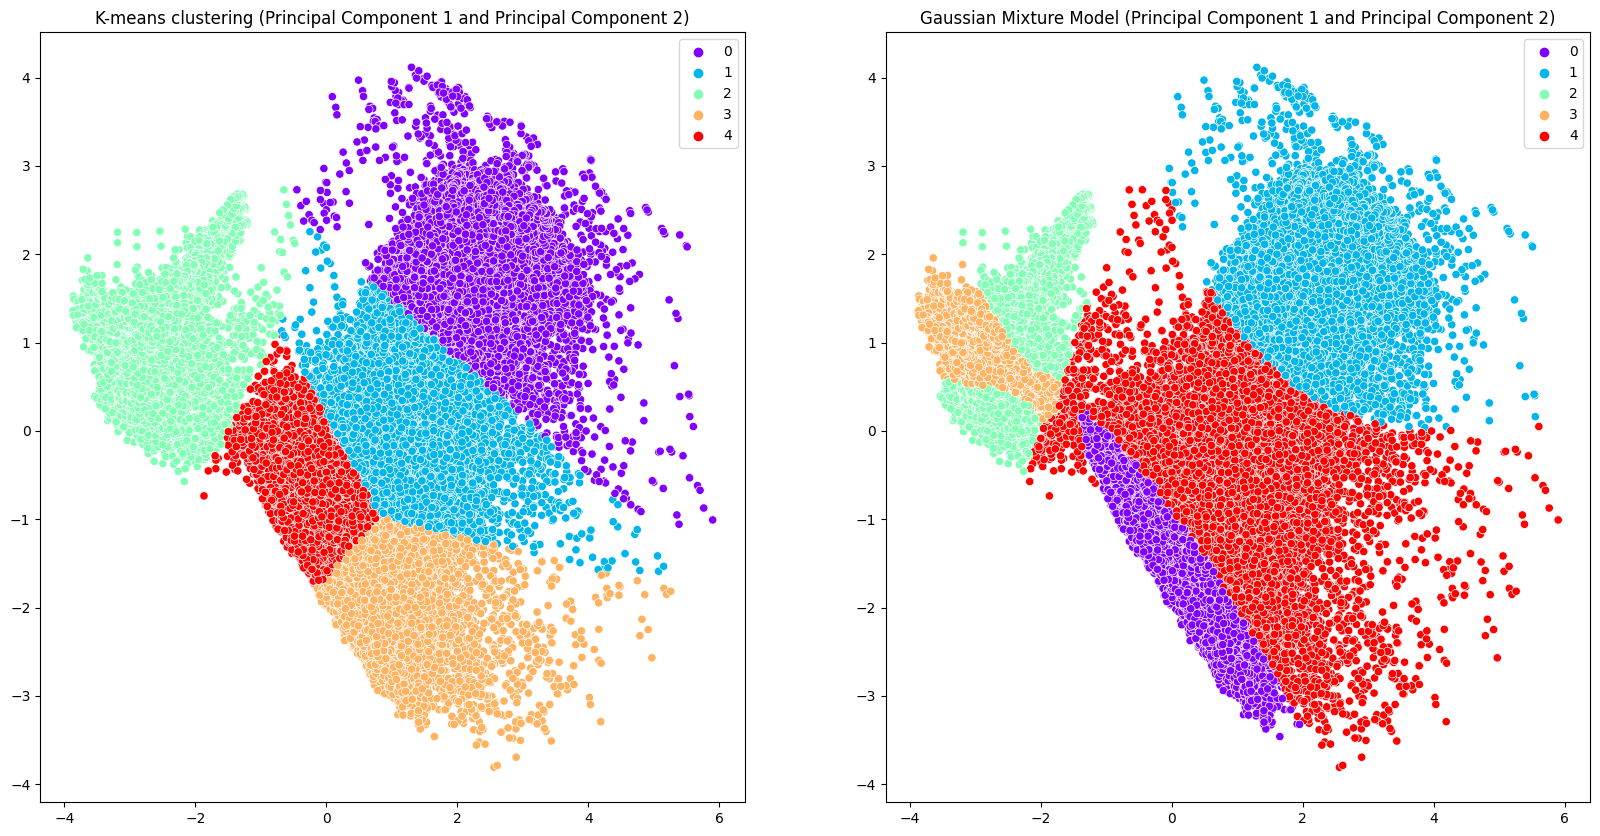

In [190]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title("K-means clustering (Principal Component 1 and Principal Component 2)")
sns.scatterplot(data=principal,x=principal[:,0],y=principal[:,1],hue=labels_kmean,palette='rainbow')
plt.subplot(1,2,2)
plt.title("Gaussian Mixture Model (Principal Component 1 and Principal Component 2)")
sns.scatterplot(data=principal,x=principal[:,0],y=principal[:,1],hue=labels,palette='rainbow')

In [191]:
from sklearn.metrics import pairwise_distances
num = 2
def confidentScore(label,principal):
    distances = pairwise_distances(principal,[kmeans.cluster_centers_[label]])
    log = distances
    confidence = (max(log)-log)/max(log)*100
    return confidence


df.loc[:, 'Label_minik'] = labels_minik
df.loc[:, 'Label_Kmean'] = labels_kmean

print("K-mean clustering : ",silhouette_score(principal,labels_kmean))
print("GMM : ",silhouette_score(principal,labels))
#print(silhouette_score(dataset,labels))

In [193]:
print(GMM.lower_bound_)

-2.671004233484527


Evaluation().silhouette(data=dataset,n=13)

In [194]:
num = 2
plt.figure(figsize=(30,10))
arr1 = plt.hist(principal[:,num],bins=200,log=False)
print(max(arr1[0]))
print(arr1[1][np.argmax((arr1[0]))])
print("Mean : ",np.mean(principal[:,num]))
print("Median : ",np.median(principal[:,num]))
plt.axvline(np.mean(principal[:,num]),c='r')
plt.axvline(np.median(principal[:,num]),c='y')

IndexError: index 2 is out of bounds for axis 1 with size 2

<Figure size 3000x1000 with 0 Axes>

{'whiskers': [<matplotlib.lines.Line2D at 0x2c9c2017730>,
 'caps': [<matplotlib.lines.Line2D at 0x2c9c2017c70>,
 'boxes': [<matplotlib.lines.Line2D at 0x2c9c2017490>],
 'medians': [<matplotlib.lines.Line2D at 0x2c9c20500d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2c9c2050370>],
 'means': []}

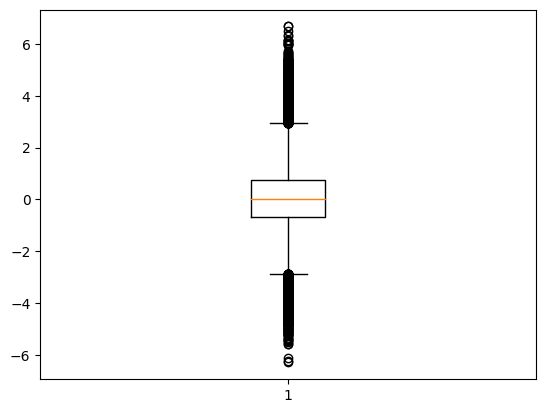

In [154]:
plt.boxplot(principal[:,num])

plt.figure(figsize=(20,10))
plt.scatter(principal[:,2],principal[:,1],c=df['Label_minik'],cmap='jet')
plt.xlabel('pc1')
plt.ylabel('pc2')

#Supervised 
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
x = dataset
y = df['Label_Kmean']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
SVM = SVC(C=1.0,kernel='linear',tol=1e-4,cache_size=400,max_iter=-1,random_state=42)
SVM.fit(X_train,y_train)
Pred_svm = SVM.predict(X_test)

from sklearn.metrics import accuracy_score,confusion_matrix
print(accuracy_score(y_test,Pred_svm))
con = confusion_matrix(y_test,Pred_svm)
sns.heatmap(data=con,annot=True)

from sklearn.model_selection import GridSearchCV

def silhouette_scorer(estimator, X):
    cluster_labels = estimator.fit_predict(X)
    return silhouette_score(X, cluster_labels)
# Example adjustment for KMeans
param_grid_kmeans = {
    'tol' : [1e-4,1e-5,1e-6],
    'n_clusters': [5, 7, 9, 11],
    'init': ['k-means++', 'random'],
    'n_init': [10, 20, 'auto'],
    'max_iter': [300, 500, 700],
    'algorithm': ['lloyd','elkan']
}
grid_search_kmeans = GridSearchCV(KMeans(random_state=42), param_grid_kmeans, cv=5, scoring=silhouette_scorer)
grid_search_kmeans.fit(dataset)  # X is your data

best_kmeans = grid_search_kmeans.best_estimator_


print(grid_search_kmeans.best_score_)
print(best_kmeans)

print(best_kmeans)

In [155]:
#print(best_kmeans)
#KMeans(n_clusters=5, n_init=20, random_state=42, tol=1e-05) : sobel
#KMeans(init='k-means++', n_clusters=5, n_init=20, random_state=42, tol=1e-05,algorithm='lloyd')

#MiniBatchKMeans(max_iter=300, n_clusters=5, n_init=10, random_state=42,tol=0.0001) : sobel
#MiniBatchKMeans(n_clusters=5,batch_size=1500, max_no_improvement=30, tol=1e-4, random_state=42, init='k-means++' ,n_init=10, max_iter=500 ,reassignment_ratio=0.001)
#--normal glcm---
#MiniBatchKMeans(batch_size=500, max_iter=300, n_clusters=5, n_init=20,random_state=42, tol=1e-05) \\ same
#KMeans(n_clusters=5, n_init='auto', random_state=42)
#---------New dataset--------#
#KMeans(n_clusters=5, n_init='auto', random_state=42)
#MiniBatchKMeans(batch_size=1036, max_iter=300, n_clusters=5, n_init=20,random_state=42, tol=0.0001)
#KMeans(algorithm='elkan', n_clusters=5, n_init=10, random_state=42)
#MiniBatchKMeans(batch_size=1036, max_iter=300, n_clusters=5, n_init=10,random_state=42, tol=1e-06)
#--------------PCA----------------------
#MiniBatchKMeans(batch_size=1536, init='random', max_iter=300, n_clusters=5,n_init=20, random_state=42, tol=1e-05)

import pickle 

with open('af_model_1.pkl','wb') as f:
    pickle.dump(af,f)

import pickle
with open('gmm_model_PCAscaled3_.pkl', 'wb') as f:
    pickle.dump(GMM, f)
with open('kmean_model_PCAscaled3_slide.pkl', 'wb') as f:
    pickle.dump(kmeans, f)
#with open('miniBkmean_model_2PCA.pkl', 'wb') as f:
    #pickle.dump(minik, f)

def ScaledPCA(self,components,scaler,dataframe):
    scaled = StandardScaler(dataframe)
    pca = PCA(n_components=components,svd_solver="full")
    principal = pca.fit_transform(scaled)
    return principal

from preprocessing import image
image_list = image.getFilename(r'C:\Users\ASUS\Documents\NARIT_internship_data\Test_folder')

filetime = []
for file in image_list:
    filetime.append(int(os.path.splitext(os.path.basename(file))[0]))


viz = visualizer()
number = 1
source_folder = r'All_sky_camera_Astropark_Chaingmai\2024-06\2024-06-12'
destination_folder = r'C:\Users\ASUS\Documents\NARIT_internship_2024\Tester'

viz.copy_matching_files(df=viz.match_label(df=df,number=number), source_folder=source_folder, destination_folder=destination_folder)

pred = prediction()
path = r'All_sky_camera_Astropark_Chaingmai\2024-06\2024-06-09\638534868144584540.png'
pred_1,pred_2,cloud_percentage,sky_status,final = pred.total_prediction(image_path=path,mask_path='mask_delete_5.png',crop_size=570,kmeans=kmeans,GMM=GMM,df=df)

mask = cv2.imread('mask_delete_5.png',cv2.IMREAD_GRAYSCALE)
mask = crop_center(img=mask,crop_size=570)
img,name = load_single_image(path=path,crop_size=570,mask=mask,apply_crop_sun=False)
image,value,RB = pred.RBsingle(input=img,dataframe=df)
cloud_ratio = pred.CloudRatio(image=img,mask=mask)

import requests
import cv2
import numpy as np
import hashlib
import time

def get_image_hash(image_data):
    return hashlib.md5(image_data).hexdigest()

image_url = "http://weather.narit.or.th/images/allskyimage/ASTROPARK/2024-08-19"
previous_hash = None

while True:
    # Fetch the image from the web
    response = requests.get(image_url)
    if response.status_code == 200:
        # Get the current hash of the image
        current_hash = get_image_hash(response.content)
        
        # Compare with the previous hash
        if current_hash != previous_hash:
            # The image has changed
            print("Image has changed, updating display...")
            image_array = np.frombuffer(response.content, np.uint8)
            image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
            cv2.imshow('Auto-Updated Image', image)
            
            # Update the previous hash
            previous_hash = current_hash
            
            # Wait for 1 second to avoid rapid flickering
            if cv2.waitKey(1000) & 0xFF == ord('q'):
                break
        else:
            print("No change detected.")
    
    # Check every 10 seconds for a change
    time.sleep(10)
    cv2.destroyAllWindows()


sns.scatterplot(data=df,x=df['contrast'],y=df['homogeneity'],hue=labels_kmean)

sns.heatmap(df.corr(),annot=True)